### Question: Which payment methods are associated with lower churn rates?

##### Expectations
By analyzing the distribution of customers across different payment methods types, we can identify trends and patterns that can help the company make informed decisions about its business strategies. For example, if a particular payment method type has a low number of customers, the company may want to consider offering promotions or incentives to attract more customers to that service. On the other hand, if a particular service type has a high number of customers, the company may want to focus its resources on maintaining the quality of that service to retain those customers.

##### Information about the data:
The data is stored in an Excel file named `Telco_customer_churn_services.xlsx`. The file contains 7043 rows. Each row represents a customer, each column contains customer’s attributes described on the column Metadata. We have 3 Payment methods listed below:
1. `Bank Withdrawal`
2. `Credit Card`
3. `Mailed Check` 

### EDA

In [1]:
# Importing the libraries
import seaborn as sns
import pandas as pd

In [2]:
# Load the data from /Dataset/Telco_customer_churn_services.xlsx
dataset1 = pd.read_excel('../../DataSet/Telco_customer_churn_services.xlsx')

In [3]:
# we need to get a column from another excel file and join it with the dataset

# Load the data from /Dataset/Telco_customer_churn.xlsx
dataset2 = pd.read_excel('../../DataSet/Telco_customer_churn.xlsx')

In [4]:
# rename the column to match the column name in the dataset
dataset2.rename(columns={'CustomerID':'Customer ID'}, inplace=True)

In [5]:
# Join the two datasets on the column 'Customer ID'
dataset = pd.merge(dataset1, dataset2, on='Customer ID')

In [6]:
dataset.columns

Index(['Customer ID', 'Count_x', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service_x',
       'Avg Monthly Long Distance Charges', 'Multiple Lines_x',
       'Internet Service_x', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security_x', 'Online Backup_x', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV_x', 'Streaming Movies_x',
       'Streaming Music', 'Unlimited Data', 'Contract_x',
       'Paperless Billing_x', 'Payment Method_x', 'Monthly Charge',
       'Total Charges_x', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Count_y', 'Country',
       'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude',
       'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service_y', 'Multiple Lines_y', 'Internet Service_y',
       'Online Security_y', 'Online Backup_y', 'Device Protection',
       'Tech Sup

In [8]:
# get column 'Payment Method_x'
payment_method = dataset['Payment Method_x']

In [11]:
# get only the required columns which are 'Churn Value' and 'Payment Method_x'
dataset = dataset[['Churn Value', 'Payment Method_x']]
# rename the column 'Payment Method_x' to 'Payment Method'
dataset.rename(columns={'Payment Method_x':'Payment Method'}, inplace=True)

In [9]:
payment_method.unique()

array(['Bank Withdrawal', 'Credit Card', 'Mailed Check'], dtype=object)

In [10]:
# Check for any missing values
payment_method.isnull().sum()

0

<AxesSubplot:xlabel='Payment Method', ylabel='count'>

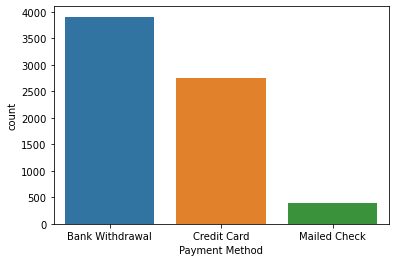

In [13]:
# make a histogram of internet type
sns.countplot(x='Payment Method', data=dataset)

<AxesSubplot:ylabel='Payment Method_x'>

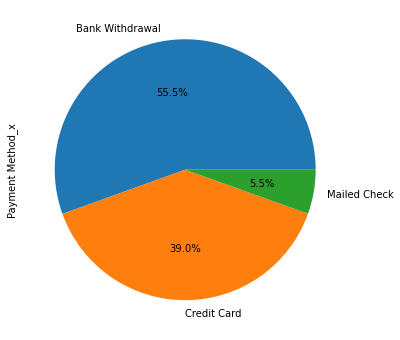

In [14]:
# make a pie chart of internet type 
payment_method.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))

    Payment Method  Churn Value  percentage
0  Bank Withdrawal            0   66.001535
1  Bank Withdrawal            1   33.998465
2      Credit Card            0   85.522008
3      Credit Card            1   14.477992
4     Mailed Check            0   63.116883
5     Mailed Check            1   36.883117


<AxesSubplot:xlabel='Payment Method', ylabel='percentage'>

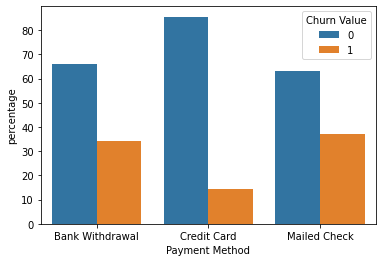

In [16]:
# calculate the proportion of churn value for each payment method type
Payment_Type_churn = dataset.groupby(['Payment Method'])['Churn Value'].value_counts(
    normalize=True).rename('percentage').mul(100).reset_index()

# print the proportion of churn value for each payment method type
print(Payment_Type_churn)

# plot the proportion of churn value for each payment method type
sns.barplot(x="Payment Method", y="percentage",
            hue="Churn Value", data=Payment_Type_churn)

#### Results Interpretation
Based on our analysis of the Telco Customer Churn dataset, we found that the distribution of customers across different Payment method types is as follows: 55.5% for Bank Withdrawal, 39% for Credit Card, 5.5% for Mailed Check.

When we analyzed the churn value for each service type, we found that Mailed Check and Bank Withdrawal Payment methods have the highest churn rates at 38% and 35%, respectively. On the other hand, customers who pay using credit cards have the lowest churn rate at nearly 14%.

Overall, our findings suggest that the company should focus on improving the quality of its Mailed Check and Bank Withdrawal Payment methods to reduce the churn rate for these services. The company should also consider offering promotions or incentives to attract more customers to its Credit Card Payment method, which has the lowest churn rate.

In [17]:
# save the internet type and churn value to an excel file
columns = ['Payment Method', 'Churn Value']
newDataset = dataset[columns]
newDataset.to_excel('Payment_method_churn.xlsx', index=False)